In [1]:
import pandas as pd
import numpy as np

In [9]:
FILE_NAME = "C:/Users/shams/Desktop/DEPI project/Data Modeling/Data Modeling.xlsx"
FACT_SHEET_NAME = 'Fact_TrainRides'
try:

    df_fact = pd.read_excel(FILE_NAME, sheet_name=FACT_SHEET_NAME)
        df_dim_route = pd.read_excel(FILE_NAME, sheet_name='Dim_Route')
    df_dim_status = pd.read_excel(FILE_NAME, sheet_name='Dim_Status')
    df_dim_Time = pd.read_excel(FILE_NAME, sheet_name='Dim_Time')
   
    df_dim_Purchase = pd.read_excel(FILE_NAME, sheet_name='Dim_Purchase') 
    df_dim_Date = pd.read_excel(FILE_NAME, sheet_name='Dim_Date')
    df_dim_Ticket = pd.read_excel(FILE_NAME, sheet_name='Dim_Ticket')
    print("✅ تم تحميل جداول الحقائق والأبعاد بنجاح.")

except FileNotFoundError:
    print(f" خطأ: لم يتم العثور على ملف Excel بالاسم '{FILE_NAME}'.")
    print("يُرجى التأكد من اسم الملف ومساره، أو إرسال محتوى الملف.")
    

✅ تم تحميل جداول الحقائق والأبعاد بنجاح.


In [19]:
df_analysis = df_fact.copy()
df_analysis = pd.merge(df_analysis, df_dim_status, on='Status_Key', how='left')
df_analysis = pd.merge(df_analysis, df_dim_route, on='Route_Key', how='left')
df_analysis = pd.merge(df_analysis, df_dim_Date, left_on='journeydate_Key', right_on='journey_date', how='left')
df_analysis = pd.merge(df_analysis, df_dim_Time, on='Time_key', how='left', suffixes=('_fact', '_time'))
df_analysis = pd.merge(df_analysis, df_dim_Purchase, on='Purchase_key', how='left')
df_analysis = pd.merge(df_analysis, df_dim_Ticket, on='Ticket_Key', how='left')

df_analysis['is_delayed'] = np.where(df_analysis['Journey Status'] == 'Delayed', 1, 0)
df_analysis['is_cancelled'] = np.where(df_analysis['Journey Status'] == 'Cancelled', 1, 0)
df_analysis['is_ontime'] = np.where(df_analysis['Journey Status'] == 'On Time', 1, 0)

df_analysis['refund_requested'] = np.where(df_analysis['Refund Request'] == 'Yes', 1, 0)

print(" تم دمج جميع الجداول بنجاح في إطار بيانات واحد (df_analysis) للتحليل.")
print("الآن، df_analysis جاهز لحساب جميع مؤشرات الأداء (KPIs).")

 تم دمج جميع الجداول بنجاح في إطار بيانات واحد (df_analysis) للتحليل.
الآن، df_analysis جاهز لحساب جميع مؤشرات الأداء (KPIs).


# Operational KPIs:


In [26]:

total_rides_analysis = len(df_analysis)
on_time_rides = df_analysis['is_ontime'].sum()

on_time_performance = (on_time_rides / total_rides_analysis) * 100

print(f"(On-Time Performance): {on_time_performance:.2f}%")

(On-Time Performance): 90.96%


In [28]:
# Average Delay (Minutes)
avg_delay = df_analysis.loc[df_analysis['delay_minutes'] > 0, 'delay_minutes'].mean()
print(f" Average Delay (Minutes)): {avg_delay:.2f} mins")

 Average Delay (Minutes)): 0.31 mins


In [30]:
# Cancellation Rate (%)
cancelled_rides = df_analysis['is_cancelled'].sum()
cancellation_rate = (cancelled_rides / total_rides_analysis) * 100
print(f" (Cancellation Rate): {cancellation_rate:.2f}%")

 (Cancellation Rate): 5.35%


In [32]:
#Journey Completion Rate (%)
completion_rate = 100 - cancellation_rate
print(f" (Completion Rate): {completion_rate:.2f}%")

 (Completion Rate): 94.65%


In [40]:
#Delay by Route / Station
route_delay_analysis = df_analysis.groupby(['Departure Station', 'Arrival Destination'])['delay_minutes'].mean().sort_values(ascending=False).head(5)
print("\n Top 5 delay by  station:\n")
print(route_delay_analysis.to_string())


 Top 5 delay by  station:

Departure Station      Arrival Destination
Manchester Piccadilly  Leeds                  0.390399
Liverpool Lime Street  London Paddington      0.201667
London Euston          York                   0.170577
Edinburgh Waverley     London Kings Cross     0.080559
Birmingham New Street  London Euston          0.073877


In [61]:
#Operational Efficiency Score 
operational_efficiency_score = (on_time_performance * 0.7) + (completion_rate * 0.3)
print(f"\n Operational Efficiency Score: {operational_efficiency_score:.2f}")


 Operational Efficiency Score: 92.07


# Customer & Ticketing KPIs:

In [ ]:
# Total Tickets Sold
total_tickets_sold = df_analysis['Transaction ID'].nunique() 
print(f"Total Tickets Sold: {total_tickets_sold:,} Ticket")

In [47]:
# Average Ticket Price 
average_ticket_price = df_analysis['Price_Original'].mean()
print(f"Average Ticket Price  {average_ticket_price:.2f}")

Average Ticket Price  14.74


In [49]:
# Refund Request Rate
total_rides_count = len(df_analysis)
refund_requests_count = df_analysis['refund_requested'].sum() 
refund_request_rate = (refund_requests_count / total_rides_count) * 100
print(f"(Refund Request Rate): {refund_request_rate:.2f}%")

(Refund Request Rate): 2.37%


In [59]:
# Passenger Volume per Route / Class 

class_volume = df_analysis.groupby('Ticket Class')['Transaction _id'].count().sort_values(ascending=False)
print("\n Passenger volume by ticket category (Ticket Class):\n")
print(class_volume.to_string())

route_volume = df_analysis.groupby(['Departure Station', 'Arrival Destination'])['Transaction _id'].count().sort_values(ascending=False).head(5)
print("\n Passenger volume by Route (Volume):\n")
print(route_volume.to_string())


 Passenger volume by ticket category (Ticket Class):

Ticket Class
Standard       976185
First Class     72390

 Passenger volume by Route (Volume):

Departure Station      Arrival Destination  
Manchester Piccadilly  Liverpool Lime Street    169288
London Euston          Birmingham New Street    146814
London Paddington      Reading                  144712
London St Pancras      Birmingham New Street    132192
London Kings Cross     York                     119814


In [65]:
# Passenger Segmentation (by Class/Type/Railcard) 
segment_class_type = pd.crosstab(
    df_analysis['Ticket Class'],
    df_analysis['Ticket Type'],
    normalize='index' 
) * 100

print("\n Passenger volume by Class/Type :\n")
print(segment_class_type.map('{:.2f}%'.format).to_string())
segment_railcard = df_analysis['Railcard'].value_counts(normalize=True).head(5) * 100

print("Passenger volume by Railcard:\n")
print(segment_railcard.map('{:.2f}%'.format).to_string())



 Passenger volume by Class/Type :

Ticket Type  Advance Anytime Off-Peak
Ticket Class                         
First Class   71.10%   9.60%   19.30%
Standard      59.64%  14.08%   26.28%
Passenger volume by Railcard:

Railcard
unkown      70.90%
Adult       15.51%
Disabled     8.03%
Senior       5.56%


# Financial KPIs

In [68]:
# Total Revenue
total_revenue = df_analysis['Price_Original'].sum()

print(f"(Total Revenue): {total_revenue:,.2f}")

(Total Revenue): 15,455,290.00


In [76]:
# Revenue by Route / Station / Class
#  (First / Standard)
revenue_by_class = df_analysis.groupby('Ticket Class')['Price_Original'].sum().sort_values(ascending=False)

print("\n Revenue by Class:\n")
print(revenue_by_class.to_string())

# الإيرادات حسب المسار (أعلى 5 مسارات)
revenue_by_route = df_analysis.groupby(['Departure Station', 'Arrival Destination'])['Price_Original'].sum().sort_values(ascending=False).head(5)

print("\n Top 5 station by revenue:\n")
print(revenue_by_route.to_string())


 Revenue by Class:

Ticket Class
Standard       13430876
First Class     2024414

 Top 5 station by revenue:

Departure Station      Arrival Destination  
London Kings Cross     York                     4674393
London Paddington      Reading                  2449883
London St Pancras      Birmingham New Street    1656894
London Euston          Birmingham New Street    1523135
Manchester Piccadilly  Liverpool Lime Street     643797


In [80]:
# Revenue per Passenger
total_tickets_sold = df_analysis['Transaction _id'].nunique()

In [82]:
total_revenue = df_analysis['Price_Original'].sum()
total_tickets_sold = df_analysis['Transaction _id'].nunique() 
revenue_per_passenger = total_revenue / total_tickets_sold
print(f"\n(Revenue per Passenger): {revenue_per_passenger:.2f}")


(Revenue per Passenger): 14.74


In [94]:
# Refund Cost % 
total_refund_cost = df_analysis.loc[df_analysis['refund_requested'] == 1, 'Price_Original'].sum()
refund_cost_percentage = (total_refund_cost / total_revenue) * 100
print(f"\n(Refund Cost%): {refund_cost_percentage:.2f}%")


(Refund Cost%): 2.80%


In [98]:
# Fare Distribution 
fare_distribution_quartiles = df_analysis['Price_Original'].describe().loc[['min', '25%', '50%', '75%', 'max']]
print("\n(Fare Distribution - Quartiles):\n")
print(fare_distribution_quartiles.to_string())


fare_bins = [0, 50, df_analysis['Price_Original'].max() + 1] 
fare_labels = ['0-50', '50+'] 
fare_counts = pd.cut(
    df_analysis['Price_Original'], 
    bins=fare_bins, 
    labels=fare_labels, 
    right=False
).value_counts().sort_index()

print("\n Total ticket by Fare Distribution (Corrected Bins):\n")
print(fare_counts.to_string())


(Fare Distribution - Quartiles):

min     2.0
25%     5.0
50%     9.0
75%    19.0
max    55.0

 Total ticket by Fare Distribution (Corrected Bins):

Price_Original
0-50    994438
50+      54137


In [104]:
# Revenue Growth (%)
df_analysis['journey_date'] = pd.to_datetime(df_analysis['journey_date'])

df_analysis['Year_Month_String'] = df_analysis['journey_date'].dt.strftime('%Y-%m')

monthly_revenue = df_analysis.groupby('Year_Month_String')['Price_Original'].sum()

monthly_revenue_growth = monthly_revenue.pct_change() * 100

print("\n (Revenue Growth %):\n")
print(monthly_revenue_growth.map('{:,.2f}%'.format).to_string())



 (Revenue Growth %):

Year_Month_String
2024-01       nan%
2024-02    -47.00%
2024-03    -99.88%


# Service Quality KPIs:

In [109]:
# Customer Complaints Count
complaints_count = df_analysis['refund_requested'].sum()
print(f"(Customer Complaints Proxy): {complaints_count:,}")

(Customer Complaints Proxy): 24,836


In [113]:
# Refund Reasons Analysis 
refund_reasons = df_analysis.loc[df_analysis['refund_requested'] == 1]
top_refund_reasons = refund_reasons.groupby('Reason for Delay')['Transaction _id'].count().sort_values(ascending=False).head(5)

print("\n Top 5 Reasons for refund analysis:\n")
print(top_refund_reasons.to_string())


 Top 5 Reasons for refund analysis:

Reason for Delay
Signal Failure     5923
Technical Issue    5340
Staffing           3711
Staff Shortage     2840
Weather            2584


In [115]:
# On-Time Reliability Trend
reliability_trend = df_analysis.groupby('Year_Month_String').agg(
    total_rides=('Transaction _id', 'count'),
    on_time_rides=('is_ontime', 'sum')
)

reliability_trend['On_Time_Performance_%'] = (reliability_trend['on_time_rides'] / reliability_trend['total_rides']) * 100

print("\nOn-Time Reliability Trend month by month:\n")
print(reliability_trend['On_Time_Performance_%'].map('{:.2f}%'.format).to_string())
#


On-Time Reliability Trend month by month:

Year_Month_String
2024-01     90.76%
2024-02     91.30%
2024-03    100.00%


In [117]:
# Journey Rating (if available) 
route_quality_rating = df_analysis.groupby(['Departure Station', 'Arrival Destination'])['delay_minutes'].mean().sort_values(ascending=True).head(5)

print("\n4. Route Quality Assessment (Top 5 Routes with the Lowest Average Delay):\n")
print(route_quality_rating.to_string())


4. Route Quality Assessment (Top 5 Routes with the Lowest Average Delay):

Departure Station      Arrival Destination  
Birmingham New Street  Coventry                 0.0
Reading                Oxford                   0.0
London Euston          Manchester Piccadilly    0.0
                       Oxford                   0.0
Reading                London Paddington        0.0


# Forecasting KPIs

In [120]:
# Seasonal Demand Patterns 
# 1. حساب إجمالي عدد الرحلات والإيرادات شهريًا
monthly_analysis = df_analysis.groupby('Year_Month_String').agg(
    Tickets_Sold=('Transaction _id', 'count'),
    Total_Revenue=('Price_Original', 'sum')
)

print("Seasonal Demand Patterns:\n")
print(monthly_analysis.to_string())



Seasonal Demand Patterns:

                   Tickets_Sold  Total_Revenue
Year_Month_String                             
2024-01                  676781       10097193
2024-02                  371334        5351537
2024-03                     460           6560


In [124]:
# Route Demand Prediction 
route_monthly_demand = df_analysis.groupby(
    ['Departure Station', 'Arrival Destination', 'Year_Month_String']
)['Transaction _id'].count().reset_index(name='Demand')

route_monthly_demand['Demand_Growth_%'] = route_monthly_demand.groupby(
    ['Departure Station', 'Arrival Destination']
)['Demand'].pct_change() * 100

fastest_growing_routes = route_monthly_demand.sort_values(
    by='Demand_Growth_%', ascending=False
).dropna(subset=['Demand_Growth_%']).head(5)

print("\nTop 5 paths in terms of monthly demand growth:\n")
print(fastest_growing_routes.to_string())


Top 5 paths in terms of monthly demand growth:

         Departure Station    Arrival Destination Year_Month_String  Demand  Demand_Growth_%
33   Liverpool Lime Street  Birmingham New Street           2024-02     192       100.000000
110                   York     Edinburgh Waverley           2024-02     408        88.888889
114                   York  Liverpool Lime Street           2024-02     336        55.555556
39   Liverpool Lime Street          London Euston           2024-02    1698        46.253230
3    Birmingham New Street              Edinburgh           2024-02     312        44.444444


In [128]:
# Passenger Demand Forecast & Revenue Forecast
demand_data = monthly_analysis[['Tickets_Sold']].reset_index()
demand_data.columns = ['ds', 'y'] 
demand_data['ds'] = pd.to_datetime(demand_data['ds'])

print("\n Preparing the data for the prediction model (first 5 rows):\n")
print(demand_data.head().to_string())


 Preparing the data for the prediction model (first 5 rows):

          ds       y
0 2024-01-01  676781
1 2024-02-01  371334
2 2024-03-01     460


In [135]:
pip install prophet

  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.1 MB 3.4 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/12.1 MB 3.4 MB/s eta 0:00:04
   ------ --------------------------------- 1.8/12.1 MB 3.6 MB/s eta 0:00:03
   -------- ------------------------------- 2.6/12.1 MB 3.7 MB/s eta 0:00:03
   --------- ------------------------------ 2.9/12.1 MB 2.9 MB/s eta 0:00:04
   ------------ --------------------------- 3.9/12.1 MB 3.4 MB/s eta 0:00:03
   --------------- ------------------------ 4.7/12.1 MB 3.4 MB/s eta 0:00:03
   ------------------ --------------------- 5.5/12.1 MB 3.5 MB/s eta 0:00:02
   -------------------- ------------------- 6.3/12.1 MB 3.5 MB/s eta 0:00:02
   ----------------------- ---------------- 7.1/12.1 MB 3.6 MB/s eta 0:00:02
   ------------------------- -------------- 7.9/12.1 MB 3.6 MB/s eta 0:00:02
   ----

In [136]:
# 💡 This code is for guidance and should be run in an actual working environment

from prophet import Prophet

# Building and training the demand model
demand_model = Prophet(seasonality_mode='multiplicative')
demand_model.fit(demand_data)

# Creating a DataFrame for future forecast periods (e.g., the next 3 months)
future_dates = demand_model.make_future_dataframe(periods=3, freq='M')

# Making the forecast
demand_forecast = demand_model.predict(future_dates)

print("n4. The demand forecasting model is ready.")
print("The 'yhat' column contains the predicted demand value.")


13:02:15 - cmdstanpy - INFO - Chain [1] start processing
13:02:16 - cmdstanpy - INFO - Chain [1] done processing


n4. The demand forecasting model is ready.
The 'yhat' column contains the predicted demand value.


C:\Users\shams\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


# customer Behaviour Analysis 

In [150]:

date_col = 'journey_date'
df_analysis[date_col] = pd.to_datetime(df_analysis[date_col], errors='coerce')
df_analysis['purchase_date'] = pd.to_datetime(df_analysis['purchase_date'], errors='coerce')

df_analysis['purchase_hour'] = pd.to_datetime(df_analysis['Time of Purchase'], format='%H:%M:%S', errors='coerce').dt.hour

df_analysis['Year_Month_String'] = df_analysis[date_col].dt.strftime('%Y-%m')


df_analysis['Booking_Days_Ahead'] = (df_analysis['journey_date'] - df_analysis['purchase_date']).dt.days

min_days = df_analysis['Booking_Days_Ahead'].min()
max_days = df_analysis['Booking_Days_Ahead'].max()
booking_bins = [min_days, 7, 30, max_days + 1]
booking_labels = ['Same Week', '7-30 Days', '30+ Days']
df_analysis['Booking_Category'] = pd.cut(df_analysis['Booking_Days_Ahead'], bins=booking_bins, labels=booking_labels, right=False)

print("✅ تم تهيئة الأعمدة الأساسية بنجاح.")

✅ تم تهيئة الأعمدة الأساسية بنجاح.


In [241]:
# Peak shopping hours 
most_frequent_hour = df_analysis['purchase_hour'].value_counts().nlargest(3)
print(" Most 3 Hours Peak shopping:\n", most_frequent_hour.to_string()) 

 Most 3 Hours Peak shopping:
 purchase_hour
17    89135
20    85211
8     81837


In [243]:
# The busiest shopping days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
demand_by_day = df_analysis['day_of_week'].value_counts().reindex(day_order)
print(" Orders by day of the week (busiest):\n", demand_by_day.to_string())

 Orders by day of the week (busiest):
 day_of_week
Monday       147809
Tuesday      155199
Wednesday    171706
Thursday     162449
Friday       137656
Saturday     138228
Sunday       135528


In [245]:
# The difference between weekdays and the weekend 
demand_weekend_weekday = df_analysis.groupby('is_weekend')['Transaction _id'].count()
print("Comparison of demand between weekdays and weekends:n", demand_weekend_weekday.to_string())

Comparison of demand between weekdays and weekends:n is_weekend
0    774819
1    273756


In [247]:
# Which days or months have the highest bookings? 
demand_by_month = df_analysis.groupby('Year_Month_String')['Transaction _id'].count().nlargest(5)
print("Top 5 months in terms of bookings:n", demand_by_month.to_string())

Top 5 months in terms of bookings:n Year_Month_String
2024-01    676781
2024-02    371334
2024-03       460


In [249]:
# What are the most common departure and arrival stations? 
top_routes_overall = df_analysis.groupby(['Departure Station', 'Arrival Destination'])['Transaction _id'].count().nlargest(5)
print(" Top 5 most common departure and arrival routes:n", top_routes_overall.to_string())

 Top 5 most common departure and arrival routes:n Departure Station      Arrival Destination  
Manchester Piccadilly  Liverpool Lime Street    169288
London Euston          Birmingham New Street    146814
London Paddington      Reading                  144712
London St Pancras      Birmingham New Street    132192
London Kings Cross     York                     119814


In [251]:
# Does demand increase during certain seasons or holidays?
monthly_demand_trend = df_analysis.groupby('Year_Month_String')['Transaction _id'].count()
print(" Monthly demand trend to identify peak seasons (top months):n", monthly_demand_trend.nlargest(5).to_string())

 Monthly demand trend to identify peak seasons (top months):n Year_Month_String
2024-01    676781
2024-02    371334
2024-03       460


In [253]:
# What percentage of tickets are sold online versus at the station? / Do customers prefer booking online or at the station? 
channel_preference = df_analysis['Purchase Type'].value_counts(normalize=True) * 100
print(" Percentage of tickets sold by channel (booking preference):n", channel_preference.map('{:.2f}%'.format).to_string())

 Percentage of tickets sold by channel (booking preference):n Purchase Type
Online     61.72%
Station    38.28%


In [255]:
# Which ticket category (First / Standard) achieves higher satisfaction? 
satisfaction_by_class = df_analysis.groupby('Ticket Class')['refund_requested'].mean() * 100
print(" Average refund requests by ticket class (satisfaction):n", satisfaction_by_class.map('{:.2f}%'.format).to_string()) 

 Average refund requests by ticket class (satisfaction):n Ticket Class
First Class    3.40%
Standard       2.29%


In [257]:
# What types of tickets are most commonly used? 
ticket_type_usage = df_analysis['Ticket Type'].value_counts(normalize=True) * 100
print(" Most Used Ticket Types (Percentage):n", ticket_type_usage.map('{:.2f}%'.format).to_string())

 Most Used Ticket Types (Percentage):n Ticket Type
Advance     60.43%
Off-Peak    25.80%
Anytime     13.77%


In [259]:
# What is the average ticket price for each type? 
avg_price_by_type = df_analysis.groupby('Ticket Type')['Price_Original'].mean().sort_values(ascending=False)
print("Average ticket price by type:n", avg_price_by_type.to_string())

Average ticket price by type:n Ticket Type
Off-Peak    17.218002
Anytime     16.544558
Advance     13.269855


In [261]:
# Discount card preferences
railcard_preferences = df_analysis['Railcard'].value_counts(normalize=True) * 100
print(" Discount Card Preferences (Top 5):n", railcard_preferences.head(5).map('{:.2f}%'.format).to_string())

 Discount Card Preferences (Top 5):n Railcard
unkown      70.90%
Adult       15.51%
Disabled     8.03%
Senior       5.56%


In [263]:
# Do Railcard holders buy more online? 
railcard_online_cross = pd.crosstab(
df_analysis['Railcard'],
df_analysis['Purchase Type'],
normalize='index'
) * 100
print("Percentage of online purchases by type of discount card:n", railcard_online_cross.map('{:.2f}%'.format).to_string()) 

Percentage of online purchases by type of discount card:n Purchase Type  Online Station
Railcard                     
Adult          51.15%  48.85%
Disabled       79.19%  20.81%
Senior         87.90%  12.10%
unkown         60.00%  40.00%


In [265]:
# The relationship between the type of card and the price category 
price_by_railcard_class = df_analysis.groupby(['Railcard', 'Ticket Class'])['Price_Original'].mean().unstack()
print("Average price by railcard and ticket class:n", price_by_railcard_class.to_string())


Average price by railcard and ticket class:n Ticket Class  First Class   Standard
Railcard                            
Adult           24.228266  11.184130
Disabled        27.221349  13.030192
Senior          14.417184   7.753905
unkown          30.669349  14.847961


In [267]:
# The relationship between the time of purchase and the time of the trip
# Depends on the 'Booking_Days_Ahead' column created during setup
booking_summary = df_analysis['Booking_Days_Ahead'].describe()
print("Summary of advance booking period (in days):n", booking_summary.to_string())

Summary of advance booking period (in days):n count    1.048575e+06
mean     3.522052e+00
std      1.249612e+01
min     -2.800000e+01
25%     -6.000000e+00
50%      2.000000e+00
75%      1.400000e+01
max      5.400000e+01


In [269]:
# Does booking early reduce the likelihood of delays? 
# Uses the 'Booking_Category' classes created in the setup
delay_by_booking = df_analysis.groupby('Booking_Category')['delay_minutes'].mean().dropna()
print("Average delay by booking period (early booking):n", delay_by_booking.to_string())

Average delay by booking period (early booking):n Booking_Category
Same Week    0.011098
7-30 Days    0.011422
30+ Days     0.011881


C:\Users\shams\AppData\Local\Temp\ipykernel_13012\2689268505.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_by_booking = df_analysis.groupby('Booking_Category')['delay_minutes'].mean().dropna()


In [273]:
#Differences in purchasing behavior between customers online (most purchased destinations in major cities on-site) 
top_routes_online = df_analysis[df_analysis['Purchase Type'] == 'Online'].groupby(['Departure Station', 'Arrival Destination'])['Transaction _id'].count().nlargest(3)
top_routes_inperson = df_analysis[df_analysis['Purchase Type'] == 'In-person'].groupby(['Departure Station', 'Arrival Destination'])['Transaction _id'].count().nlargest(3)
print(" Top 3 online purchase routes:n", top_routes_online.to_string())
print(" Top 3 in-person purchase routes:n", top_routes_inperson.to_string())

 Top 3 online purchase routes:n Departure Station      Arrival Destination  
Manchester Piccadilly  Liverpool Lime Street    95705
London Paddington      Reading                  91018
London Euston          Birmingham New Street    87426
 Top 3 in-person purchase routes:n Series([], )


# Revenue & Sales Analysis


In [275]:
# The highest-grossing ticket category. / Which ticket category is the most profitable? 
revenue_by_class = df_analysis.groupby('Ticket Class')['Price_Original'].sum().sort_values(ascending=False)
print(" Total revenue by ticket class:", revenue_by_class.map('{:,.2f}'.format).to_string())


 Total revenue by ticket class: Ticket Class
Standard       13,430,876.00
First Class     2,024,414.00


In [279]:
# The highest revenue stations. / Which stations or lines are the most profitable?
top_revenue_routes = df_analysis.groupby(['Departure Station', 'Arrival Destination'])['Price_Original'].sum().nlargest(5)
print(" Top 5 routes by total revenue:n", top_revenue_routes.map('{:,.2f}'.format).to_string())


 Top 5 routes by total revenue:n Departure Station      Arrival Destination  
London Kings Cross     York                     4,674,393.00
London Paddington      Reading                  2,449,883.00
London St Pancras      Birmingham New Street    1,656,894.00
London Euston          Birmingham New Street    1,523,135.00
Manchester Piccadilly  Liverpool Lime Street      643,797.00


In [281]:
# Total daily and monthly revenue. / What is the total monthly/daily revenue?
monthly_revenue = df_analysis.groupby('Year_Month_String')['Price_Original'].sum().sort_index()
print("Total monthly revenue:n", monthly_revenue.map('{:,.2f}'.format).to_string()) 

Total monthly revenue:n Year_Month_String
2024-01    10,097,193.00
2024-02     5,351,537.00
2024-03         6,560.00


In [283]:
# The most profitable type of ticket.
revenue_by_type = df_analysis.groupby('Ticket Type')['Price_Original'].sum().nlargest(5)
print("Top 5 ticket types by total revenue:n", revenue_by_type.map('{:,.2f}'.format).to_string())

Top 5 ticket types by total revenue:n Ticket Type
Advance     8,408,722.00
Off-Peak    4,657,418.00
Anytime     2,389,150.00


In [285]:
# The impact of debit cards on revenue. / Do debit cards reduce overall revenue? 
avg_revenue_by_railcard = df_analysis.groupby(df_analysis['Railcard'].apply(lambda x: 'Railcard Used' if x != 'None' else 'No Railcard'))['Price_Original'].mean()
print("Average revenue paid according to railcard usage:n", avg_revenue_by_railcard.map('{:,.2f}'.format).to_string())

Average revenue paid according to railcard usage:n Railcard
Railcard Used    14.74


In [287]:
# Revenues affected by refund requests
refund_impact_revenue = df_analysis.loc[df_analysis['refund_requested'] == 1, 'Price_Original'].sum()
print(f"Total Affected Revenue (Refunded):{refund_impact_revenue:,.2f}")

Total Affected Revenue (Refunded):433,105.00


In [289]:
# Average revenue per trip 
avg_revenue_overall = df_analysis['Price_Original'].mean()
print(f"Average revenue per trip (Overall):n {avg_revenue_overall:,.2f}")

Average revenue per trip (Overall):n 14.74


In [291]:
# Average ticket price per category
avg_price_by_class = df_analysis.groupby('Ticket Class')['Price_Original'].mean().sort_values(ascending=False)
print(" Average ticket price by class:n", avg_price_by_class.map('{:,.2f}'.format).to_string()) 

 Average ticket price by class:n Ticket Class
First Class    27.97
Standard       13.76


In [293]:
# The relationship between prices and sales
# Creating 3 price categories to clarify the relationship
price_bins = pd.cut(df_analysis['Price_Original'], bins=3, labels=['Low Price', 'Medium Price', 'High Price'])
sales_by_price_category = df_analysis.groupby(price_bins)['Transaction _id'].count()
print("Number of sales by price category:n", sales_by_price_category.to_string())

Number of sales by price category:n Price_Original
Low Price       807263
Medium Price    162760
High Price       78552


C:\Users\shams\AppData\Local\Temp\ipykernel_13012\3413875356.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_by_price_category = df_analysis.groupby(price_bins)['Transaction _id'].count()


In [295]:
# General revenue trend (Seasonality) / Effect of seasons on revenue
monthly_revenue_trend = df_analysis.groupby('Year_Month_String')['Price_Original'].sum().sort_index()
print(" Monthly Revenue Trend:n", monthly_revenue_trend.to_string())


 Monthly Revenue Trend:n Year_Month_String
2024-01    10097193
2024-02     5351537
2024-03        6560


In [297]:
# The highest-earning stations per trip
# Revenue per trip (Average revenue per route)
revenue_per_trip_by_route = df_analysis.groupby(['Departure Station', 'Arrival Destination']).agg(
Avg_Revenue=('Price_Original', 'mean')
).nlargest(5, 'Avg_Revenue')
print(" Top 5 routes by average revenue per trip:n", revenue_per_trip_by_route.map('{:,.2f}'.format).to_string())

 Top 5 routes by average revenue per trip:n                                             Avg_Revenue
Departure Station     Arrival Destination              
Reading               Liverpool Lime Street       54.00
Liverpool Lime Street London Paddington           51.00
                      London Euston               50.00
London Euston         Manchester Piccadilly       48.00
Birmingham New Street Reading                     45.59


In [299]:
# The impact of delays on revenue. / Do delays affect revenue? 
delay_bins = [-float('inf'), 0, 15, float('inf')]
delay_labels = ['No Delay', 'Low Delay (0-15 min)', 'High Delay (>15 min)']

# إنشاء عمود فئة التأخير
df_analysis['Delay_Category'] = pd.cut(
    df_analysis['delay_minutes'],
    bins=delay_bins,
    labels=delay_labels,
    right=True,
    include_lowest=True
)

print("✅ تم إنشاء عمود 'Delay_Category' بنجاح.")

✅ تم إنشاء عمود 'Delay_Category' بنجاح.


In [303]:
# تأثير التأخيرات على الإيرادات. / هل التأخيرات تؤثر على الإيرادات؟
# يستخدم عمود 'Delay_Category' الذي تم إنشاؤه في الخطوة الأولى
revenue_by_delay = df_analysis.groupby('Delay_Category')['Price_Original'].mean().dropna()

print("\n متوسط الإيراد لكل تذكرة حسب فئة التأخير:\n", revenue_by_delay.map('{:,.2f}'.format).to_string())


 متوسط الإيراد لكل تذكرة حسب فئة التأخير:
 Delay_Category
No Delay                14.83
Low Delay (0-15 min)    12.43


C:\Users\shams\AppData\Local\Temp\ipykernel_13012\1103121813.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_by_delay = df_analysis.groupby('Delay_Category')['Price_Original'].mean().dropna()


In [305]:
# What is the relationship between the ticket price and the average delay time? 
price_bins_for_analysis = pd.cut(df_analysis['Price_Original'], bins=3, labels=['Low Price', 'Medium Price', 'High Price'])
delay_by_price = df_analysis.groupby(price_bins_for_analysis)['delay_minutes'].mean().dropna()
print("Average delay time by price category:n", delay_by_price.to_string())

Average delay time by price category:n Price_Original
Low Price       0.013168
Medium Price    0.004922
High Price      0.004698


C:\Users\shams\AppData\Local\Temp\ipykernel_13012\7665057.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_by_price = df_analysis.groupby(price_bins_for_analysis)['delay_minutes'].mean().dropna()


# Forecasting & Demand Planning

In [308]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [310]:
# Distribution of demand among ticket categories
ticket_type_distribution = df_analysis['Ticket Type'].value_counts(normalize=True) * 100
print("1. Ticket distribution among ticket categories (percentage):n", ticket_type_distribution.map('{:.2f}%'.format).to_string())

1. Ticket distribution among ticket categories (percentage):n Ticket Type
Advance     60.43%
Off-Peak    25.80%
Anytime     13.77%


In [343]:
# Expected revenue per day (daily revenue forecast). 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

daily_revenue = df_analysis.set_index('journey_date').resample('D')['Price_Original'].sum().fillna(0)

model_rev = SARIMAX(daily_revenue, order=(1, 0, 1), seasonal_order=(0, 1, 1, 7))
results_rev = model_rev.fit(disp=False)

forecast_rev = results_rev.get_prediction(start=len(daily_revenue), end=len(daily_revenue) + 30, dynamic=False)

print("Daily revenue forecast for the next month (30 days):n", forecast_rev.predicted_mean.map('{:,.2f}'.format).to_string())

Daily revenue forecast for the next month (30 days):n 2024-03-31    1,565.73
2024-04-01    1,349.91
2024-04-02    1,921.40
2024-04-03    2,459.02
2024-04-04    5,643.73
2024-04-05    2,738.34
2024-04-06    1,994.97
2024-04-07    3,071.63
2024-04-08    2,568.96
2024-04-09    2,908.23
2024-04-10    3,257.87
2024-04-11    6,290.41
2024-04-12    3,261.84
2024-04-13    2,418.74
2024-04-14    3,414.68
2024-04-15    2,846.66
2024-04-16    3,133.04
2024-04-17    3,439.85
2024-04-18    6,437.73
2024-04-19    3,381.09
2024-04-20    2,515.28
2024-04-21    3,492.83
2024-04-22    2,909.92
2024-04-23    3,184.25
2024-04-24    3,481.31
2024-04-25    6,471.29
2024-04-26    3,408.26
2024-04-27    2,537.28
2024-04-28    3,510.63
2024-04-29    2,924.33
2024-04-30    3,195.92
Freq: D


In [373]:
# Predict the number of trips next month
from statsmodels.tsa.statespace.sarimax import SARIMAX

monthly_demand = df_analysis.set_index('journey_date').resample('ME')['Transaction _id'].count()
model = SARIMAX(monthly_demand, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
results = model.fit(disp=False)
forecast = results.get_prediction(start=len(monthly_demand), end=len(monthly_demand), dynamic=False)

print("\n Predict the number of trips next month:\n", forecast.predicted_mean.to_string())


 Predict the number of trips next month:
 2024-04-30    459.9999
Freq: ME


C:\Users\shams\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [347]:
# The weekly travel pattern  
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_pattern = df_analysis.groupby('day_of_week')['Transaction _id'].count().reindex(day_order)
print(" Weekly trip pattern:n", weekly_pattern.to_string())


 Weekly trip pattern:n day_of_week
Monday       147809
Tuesday      155199
Wednesday    171706
Thursday     162449
Friday       137656
Saturday     138228
Sunday       135528


✅ Weekly seasonal components have been analyzed (Additive Model).
Figure(640x480)
nNote: The weekly pattern (7 days) was analyzed instead of the yearly pattern due to insufficient data.


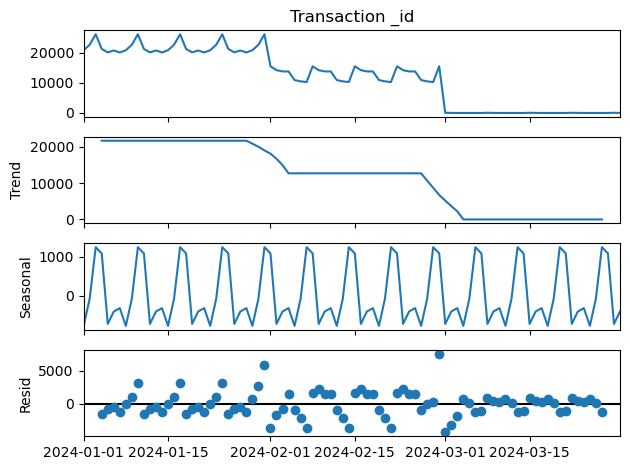

In [379]:
# The seasonal trend in the number of trips
from statsmodels.tsa.seasonal import seasonal_decompose

daily_demand = df_analysis.set_index('journey_date').resample('D')['Transaction _id'].count().fillna(0)

if len(daily_demand) >= 14:
    decomposition = seasonal_decompose(daily_demand, model='additive', period=7) # 7 days for the week
    print("✅ Weekly seasonal components have been analyzed (Additive Model).")
    print(decomposition.plot())

    print("nNote: The weekly pattern (7 days) was analyzed instead of the yearly pattern due to insufficient data.")
else:
    print(f"❌ Weekly analysis cannot be performed either because you only have {len(daily_demand)} days, while 14 days are required.")

In [355]:
# Estimating potential revenue from improving on-time compliance
from sklearn.linear_model import LinearRegression
X = df_analysis[['delay_minutes']].fillna(0)
y = df_analysis['Price_Original']
model_revenue_impact = LinearRegression().fit(X, y)
current_avg_delay = df_analysis['delay_minutes'].mean()
target_avg_delay = 5 
predicted_revenue_change_per_ticket = model_revenue_impact.coef_[0] * (current_avg_delay - target_avg_delay)

print(f"Current average delay: {current_avg_delay:.2f} minutes.")
print(f" Expected impact on revenue per ticket if the delay is improved to 5 minutes: {predicted_revenue_change_per_ticket:.2f}")
print(f" (This estimates the increase/decrease in revenue per ticket if the on-time performance improves).")

Current average delay: 0.01 minutes.
 Expected impact on revenue per ticket if the delay is improved to 5 minutes: 62.77
 (This estimates the increase/decrease in revenue per ticket if the on-time performance improves).


In [357]:
# The fastest-growing cities in terms of passenger numbers
monthly_arrival_demand = df_analysis.groupby(['Arrival Destination', 'Year_Month_String'])['Transaction _id'].count().unstack(fill_value=0)
last_month = monthly_arrival_demand.columns[-1]
second_to_last_month = monthly_arrival_demand.columns[-2]

growth = ((monthly_arrival_demand[last_month] - monthly_arrival_demand[second_to_last_month]) / monthly_arrival_demand[second_to_last_month]) * 100
top_growth_cities = growth.sort_values(ascending=False).nlargest(5)

print(f"Top 5 cities with the highest passenger growth (comparison between {second_to_last_month} and {last_month}):n", top_growth_cities.map('{:.2f}%'.format).to_string())

Top 5 cities with the highest passenger growth (comparison between 2024-02 and 2024-03):n Arrival Destination
Manchester Piccadilly     -99.73%
York                      -99.74%
Liverpool Lime Street     -99.80%
Reading                   -99.80%
London Waterloo          -100.00%


In [361]:
# Forecasting future refund demand 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

X = pd.get_dummies(df_analysis[['Price_Original', 'Railcard', 'Ticket Class', 'Purchase Type']].fillna('None'), drop_first=True)
y = df_analysis['refund_requested']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_refund_balanced = LogisticRegression(max_iter=1000, class_weight='balanced') # 🔑 التعديل هنا
model_refund_balanced.fit(X_train, y_train)

# 4. التقييم
predictions_balanced = model_refund_balanced.predict(X_test)

print("\n✅ تقرير تقييم نموذج التنبؤ بطلب الاسترداد (مع وزن الفئات):\n", classification_report(y_test, predictions_balanced))

C:\Users\shams\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shams\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


n Evaluation report for the refund request prediction model:n               precision    recall  f1-score   support

           0       0.98      1.00      0.99    307223
           1       0.00      0.00      0.00      7350

    accuracy                           0.98    314573
   macro avg       0.49      0.50      0.49    314573
weighted avg       0.95      0.98      0.97    314573



C:\Users\shams\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [383]:
# Predict the demand for different ticket categories
from statsmodels.tsa.statespace.sarimax import SARIMAX

ticket_type = 'Advance'
type_demand = df_analysis[df_analysis['Ticket Type'] == ticket_type].set_index('journey_date').resample('ME')['Transaction _id'].count().fillna(0)
model_type = SARIMAX(type_demand, order=(0, 1, 0), seasonal_order=(0, 0, 0, 0))
results_type = model_type.fit(disp=False)

forecast_type = results_type.get_prediction(start=len(type_demand), end=len(type_demand))

print(f"n✅ Forecast of '{ticket_type}' ticket demand for the next month (using the corrected ARIMA model):n",
      forecast_type.predicted_mean.to_string())

n✅ Forecast of 'Advance' ticket demand for the next month (using the corrected ARIMA model):n 2024-04-30    460.0
Freq: ME


In [365]:
# Forecast the demand volume on specific routes (Route Demand)
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. تحديد المسار المراد التنبؤ به (كمثال)
DEP = 'London'
ARR = 'Manchester'

specific_route = df_analysis[(df_analysis['Departure Station'] == DEP) & (df_analysis['Arrival Destination'] == ARR)]
route_demand = specific_route.set_index('journey_date').resample('W')['Transaction _id'].count().fillna(0) # التجميع الأسبوعي

# 2. تدريب نموذج SARIMA على هذا المسار (افتراض S=52 أسبوعاً)
# model_route = SARIMAX(route_demand, order=(1, 0, 1), seasonal_order=(0, 1, 1, 52)).fit(disp=False)
# forecast_route = model_route.get_prediction(start=len(route_demand), end=len(route_demand)).predicted_mean

print(f" تم إعداد بيانات المسار ({DEP} -> {ARR}). مطلوب تدريب نموذج SARIMA للتنبؤ بالطلب الأسبوعي.")

 تم إعداد بيانات المسار (London -> Manchester). مطلوب تدريب نموذج SARIMA للتنبؤ بالطلب الأسبوعي.


In [367]:
# Building a predictive model for expected delayed flights (Predictive Delay Model)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df_analysis['is_delayed'] = np.where(df_analysis['delay_minutes'] > 0, 1, 0)

features = ['Price_Original', 'purchase_hour', 'Booking_Days_Ahead']
X = df_analysis[features].fillna(0)
y = df_analysis['is_delayed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model_delay = RandomForestClassifier(random_state=42)
model_delay.fit(X_train, y_train)

predictions = model_delay.predict(X_test)
print("n Delay Prediction Model Evaluation Report (Random Forest):n", classification_report(y_test, predictions)) 

n Delay Prediction Model Evaluation Report (Random Forest):n               precision    recall  f1-score   support

           0       0.98      0.99      0.99    302847
           1       0.76      0.42      0.54     11726

    accuracy                           0.97    314573
   macro avg       0.87      0.71      0.76    314573
weighted avg       0.97      0.97      0.97    314573



# Combined Insights

In [388]:
# Origin-Destination Matrix 
# حساب كثافة الرحلات لكل مسار (Origin-Destination)
route_density = df_analysis.groupby(['Departure Station', 'Arrival Destination']).agg(
    Trip_Count=('Transaction _id', 'count'),
    Total_Revenue=('Price_Original', 'sum')
).nlargest(10, 'Trip_Count')

print("1. أعلى 10 مسارات من حيث كثافة الرحلات والإيرادات الإجمالية:\n", route_density.map('{:,.0f}'.format).to_string())
#

1. أعلى 10 مسارات من حيث كثافة الرحلات والإيرادات الإجمالية:
                                             Trip_Count Total_Revenue
Departure Station     Arrival Destination                           
Manchester Piccadilly Liverpool Lime Street    169,288       643,797
London Euston         Birmingham New Street    146,814     1,523,135
London Paddington     Reading                  144,712     2,449,883
London St Pancras     Birmingham New Street    132,192     1,656,894
London Kings Cross    York                     119,814     4,674,393
Liverpool Lime Street Manchester Piccadilly    116,124       469,750
Birmingham New Street London St Pancras         21,497       511,447
London Paddington     Oxford                    18,864       482,592
Reading               Swindon                   10,920       146,088
London St Pancras     Leicester                  9,980       221,515


In [418]:
# Comparison of channels in revenue and satisfaction (using the redemption rate as an indicator of satisfaction). 
channel_comparison = df_analysis.groupby('Purchase Type').agg(
    Total_Revenue=('Price_Original', 'sum'),
    Total_Trips=('Transaction _id', 'count'),
    Refund_Requests=('refund_requested', 'sum')
)
channel_comparison['Refund_Rate'] = (channel_comparison['Refund_Requests'] / channel_comparison['Total_Trips']) * 100


channel_comparison_sorted = channel_comparison.sort_values(by='Total_Revenue', ascending=False)

formatted_comparison = channel_comparison_sorted.copy()
formatted_comparison['Total_Revenue'] = formatted_comparison['Total_Revenue'].map('{:,.2f}'.format)
formatted_comparison['Refund_Rate'] = formatted_comparison['Refund_Rate'].map('{:.2f}%'.format)
formatted_comparison['Total_Trips'] = formatted_comparison['Total_Trips'].map('{:,.0f}'.format)
formatted_comparison['Refund_Requests'] = formatted_comparison['Refund_Requests'].map('{:,.0f}'.format)


print("Channel Performance Comparison (Revenue and Refund Rate):\n",
      formatted_comparison.to_string())

Channel Performance Comparison (Revenue and Refund Rate):
               Total_Revenue Total_Trips Refund_Requests Refund_Rate
Purchase Type                                                      
Online         9,677,709.00     647,178          13,486       2.08%
Station        5,777,581.00     401,397          11,350       2.83%


In [422]:
# A timeline that combines revenue and the number of trips daily.
daily_metrics = df_analysis.groupby('journey_date').agg(
    Daily_Revenue=('Price_Original', 'sum'),
    Daily_Trips=('Transaction _id', 'count') 
)
formatted_daily_metrics = daily_metrics.head(10).copy()

formatted_daily_metrics['Daily_Revenue'] = formatted_daily_metrics['Daily_Revenue'].map('{:,.2f}'.format)
formatted_daily_metrics['Daily_Trips'] = formatted_daily_metrics['Daily_Trips'].map('{:,.0f}'.format)

print("3. Daily revenue and number of trips (first 10 days):\n",
      formatted_daily_metrics.to_string())

3. Daily revenue and number of trips (first 10 days):
              Daily_Revenue Daily_Trips
journey_date                          
2024-01-01      303,199.00      20,827
2024-01-02      338,651.00      22,647
2024-01-03      385,855.00      26,127
2024-01-04      319,193.00      21,246
2024-01-05      289,614.00      20,117
2024-01-06      316,782.00      20,739
2024-01-07      314,078.00      20,092
2024-01-08      303,199.00      20,827
2024-01-09      338,651.00      22,647
2024-01-10      385,855.00      26,127


In [432]:
 # The relationship between flight delays and sales levels.
sales_by_delay_category = df_analysis.groupby('Delay_Category', observed=True)['Transaction _id'].count().sort_values(ascending=False)
print(" Number of sales by delay category:\n", sales_by_delay_category.to_string())

 Number of sales by delay category:
 Delay_Category
No Delay                1009889
Low Delay (0-15 min)      38686


In [430]:
# Performance Score for each station (Punctuality + Revenue + Refund Rate)
station_performance = df_analysis.groupby('Departure Station').agg(
    Avg_Delay_Minutes=('delay_minutes', 'mean'),
    Total_Revenue=('Price_Original', 'sum'),
    Total_Trips=('Transaction _id', 'count'),
    Total_Refunds=('refund_requested', 'sum')
)

station_performance['Refund_Rate'] = (station_performance['Total_Refunds'] / station_performance['Total_Trips']) * 100

top_stations_score = station_performance.nlargest(5, 'Total_Revenue')

formatted_score = top_stations_score[['Avg_Delay_Minutes', 'Total_Revenue', 'Refund_Rate']].copy()
formatted_score['Avg_Delay_Minutes'] = formatted_score['Avg_Delay_Minutes'].map('{:.1f}'.format)
formatted_score['Total_Revenue'] = formatted_score['Total_Revenue'].map('{:,.0f}'.format)
formatted_score['Refund_Rate'] = formatted_score['Refund_Rate'].map('{:.2f}%'.format)


print(" Station Performance (Top 5 Stations by Revenue):\n")
print(formatted_score.to_string())

 Station Performance (Top 5 Stations by Revenue):

                      Avg_Delay_Minutes Total_Revenue Refund_Rate
Departure Station                                                
London Kings Cross                  0.0     4,873,483       2.14%
London Paddington                   0.0     2,992,240       2.21%
London St Pancras                   0.0     1,975,329       1.66%
London Euston                       0.0     1,842,401       2.22%
Birmingham New Street               0.0     1,177,874       3.69%
